## Non-deterministic state history

In this tutorial we shall consider a few examples whose aim is to emphasise
and remind users that the Deltaflow language is designed to control
asyncronous processes.
It means that the design of the program (graph) should include potential
delays in latencies of nodes as well as data transfer,
which should not affect the final result.

Depending on the form of the final result different strategies can be used.

Let us first begin with defining some helper interactive nodes used
for our examples below:

In [1]:
import random
import time

import deltalanguage as dl


ITER_NUM = 9


# sends out several identialal integers
@dl.Interactive({}, int)
def start(node):
    for _ in range(ITER_NUM):
        node.send(1)


# receives the same number of messages end exit
@dl.Interactive({"a": int}, dl.Void, name='finish')
def finish1(node):
    for _ in range(ITER_NUM):
        inputs = node.receive()

    raise dl.DeltaRuntimeExit


# receives the same number of message pairs end exit
@dl.Interactive({"a": int, "b": int}, dl.Void, name='finish')
def finish2(node):
    for _ in range(ITER_NUM):
        inputs = node.receive()

    raise dl.DeltaRuntimeExit

# receives and sends messages as a batch
@dl.Interactive({"a": int}, int)
def checker(node):
    memory = []
    for _ in range(ITER_NUM):
        memory.append(node.receive('a'))

    memory.reverse()
    for _ in range(ITER_NUM):
        node.send(memory.pop())

Now the intersting bit, we create 2 nodes attached to the same state.
Both nodes can read, modify, and write this state.

In order to make this example more illustrative we have explicitly
added randomised time delays in these nodes:

In [2]:
class MyBadExample:

    def __init__(self, x):
        self.state = x

    @dl.DeltaMethodBlock()
    def adder(self, a: int) -> int:
        time.sleep(0.01*random.random())
        self.state += a
        print(self.state, end='')
        return a

    @dl.DeltaMethodBlock()
    def subtractor(self, a: int) -> int:
        time.sleep(0.01*random.random())
        self.state -= a
        print(self.state, end='')
        return a


my_bad_example = MyBadExample(0)

### Example 1: parallel connection

Now let us connnect the graph in the way that the two troublesome nodes
are hooked up in parallel:

In [3]:
with dl.DeltaGraph() as graph:
    start_out = start.call()
    finish2.call(a=my_bad_example.adder(start_out),
                 b=my_bad_example.subtractor(start_out))

Let's see how the graph looks like, but first let's add splitter nodes for
a better illustration:

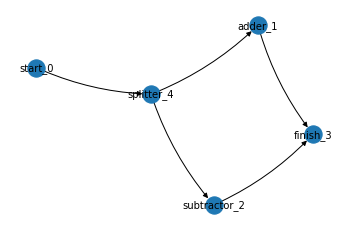

In [4]:
graph.do_automatic_splitting()
graph.draw(seed=5)

In fact we have here a receipe for disaster.
The nodes run as independent processes and the order in which the state is accessed
is not determined.

Try to run the following cell multiple times and note that even though the 
final state is correct the history of changes is different each time:

In [5]:
dl.DeltaPySimulator(graph).run()

# check the final state
assert my_bad_example.state == 0

-1-2-1-2-3-2-3-2-3-4-3-2-3-2-10-10

### Example 2: sequentially connection

Also do not trick yourself by thinking that if the troublesome nodes are connected
sequentially then the history of states will become determined:

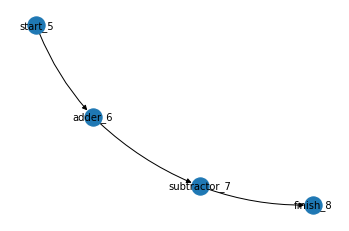

In [6]:
with dl.DeltaGraph() as graph:
    start_out = start.call()
    adder_out = my_bad_example.adder(start_out)
    subtractor_out = my_bad_example.subtractor(adder_out)
    finish1.call(a=subtractor_out)

graph.draw(seed=4)

As before try to run this graph several times and note the difference:

In [7]:
dl.DeltaPySimulator(graph).run()

# check the final state
assert my_bad_example.state == 0

101210101010123210

What happens is that once the first node processes the first message and
passes it over to the second node, the processing of data becomes parallel
from this moment.

### Example 3: isolation of the state

In order to make the history of states determined we need to make them
access the state sequentially. It can be done like this:

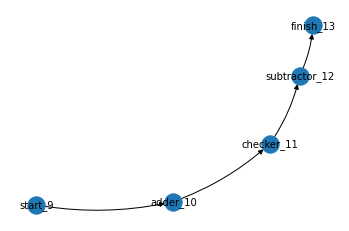

In [8]:
with dl.DeltaGraph() as graph:
    start_out = start.call()
    adder_out = my_bad_example.adder(start_out)
    checker_out = checker.call(a=adder_out)
    subtractor_out = my_bad_example.subtractor(checker_out)
    finish1.call(a=subtractor_out)

graph.draw(seed=1)

Note that the result is fixed indeed:

In [9]:
dl.DeltaPySimulator(graph).run()

# check the final state
assert my_bad_example.state == 0

123456789876543210

### Conclusion

Depending on the task you are trying to handle it may or may not be a problem
that the history of states is not deterministic.
In general you should be very cautious about using states with
the Deltaflow language, especially when they are accessed by different nodes.

The use of extra nodes that prevents conflicting nodes from modifying the same
state will make the history of states deterministic, if needed.
On the other hand this logical separation of the graph will
prevend parallelism thus slowing down the running stage.

Another important point to take into consideration is running on the actual hardware.
Whereas sharing of states between nodes is possible in the testing python runtime
and runtime simulator, it might be not the case for the hardware runtime as
nodes end up on different physical components without shared memory.